In [1]:
import sys
import os

sys.path.append(os.path.abspath(os.path.join(os.getcwd(), '..')))

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from imblearn.over_sampling import SMOTE
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import (
    classification_report, confusion_matrix, roc_auc_score,
    precision_recall_curve, average_precision_score
)
from src.utils import evaluate_model
from src.preprocessing import build_preprocessing_pipeline
%matplotlib inline

# For any warnings
import warnings
warnings.filterwarnings('ignore')

SEED = 42

In [3]:
df = pd.read_csv('../data/creditcard.csv')
df.head()

,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
0,0.0,-1.359807,-0.072781,2.536347,1.378155,-0.338321,0.462388,0.239599,0.098698,0.363787,...,-0.018307,0.277838,-0.110474,0.066928,0.128539,-0.189115,0.133558,-0.021053,149.62,0
1,0.0,1.191857,0.266151,0.166480,0.448154,0.060018,-0.082361,-0.078803,0.085102,-0.255425,...,-0.225775,-0.638672,0.101288,-0.339846,0.167170,0.125895,-0.008983,0.014724,2.69,0
2,1.0,-1.358354,-1.340163,1.773209,0.379780,-0.503198,1.800499,0.791461,0.247676,-1.514654,...,0.247998,0.771679,0.909412,-0.689281,-0.327642,-0.139097,-0.055353,-0.059752,378.66,0
3,1.0,-0.966272,-0.185226,1.792993,-0.863291,-0.010309,1.247203,0.237609,0.377436,-1.387024,...,-0.108300,0.005274,-0.190321,-1.175575,0.647376,-0.221929,0.062723,0.061458,123.50,0
4,2.0,-1.158233,0.877737,1.548718,0.403034,-0.407193,0.095921,0.592941,-0.270533,0.817739,...,-0.009431,0.798278,-0.137458,0.141267,-0.206010,0.502292,0.219422,0.215153,69.99,0


In [4]:
X = df.drop(columns='Class')
y = df['Class']

v_features = [f'V{i}' for i in range(1, 29)]

In [ ]:
X_raw = df[['Amount', 'Time'] + v_features]
y = df['Class']

# Split first
X_train_raw, X_test_raw, y_train, y_test = train_test_split(X_raw, y, stratify=y, random_state=SEED)

# Then fit pipeline on training data only
pipeline = build_preprocessing_pipeline()
X_train = pipeline.fit_transform(X_train_raw)
X_test = pipeline.transform(X_test_raw)

In [6]:
rf_original = RandomForestClassifier(n_estimators=100, random_state=SEED, class_weight=None)
rf_original.fit(X_train, y_train)
precision_rf_orig, recall_rf_orig, pr_auc_rf_orig = evaluate_model(rf_original, X_test, y_test, "Random Forest (Original)")


Evaluation: Random Forest (Original)
Confusion Matrix:
 [[71074     5]
 [   26    97]]
Classification Report:
               precision    recall  f1-score   support

           0       1.00      1.00      1.00     71079
           1       0.95      0.79      0.86       123

    accuracy                           1.00     71202
   macro avg       0.98      0.89      0.93     71202
weighted avg       1.00      1.00      1.00     71202

ROC AUC Score: 0.9457 (reference)
PR AUC Score: 0.8442


In [7]:
smote = SMOTE(random_state=SEED)
X_train_smote, y_train_smote = smote.fit_resample(X_train, y_train)

rf_smote = RandomForestClassifier(n_estimators=100, random_state=SEED)
rf_smote.fit(X_train_smote, y_train_smote)
precision_rf_smote, recall_rf_smote, pr_auc_rf_smote = evaluate_model(rf_smote, X_test, y_test, "Random Forest (SMOTE)")


Evaluation: Random Forest (SMOTE)
Confusion Matrix:
 [[71072     7]
 [   25    98]]
Classification Report:
               precision    recall  f1-score   support

           0       1.00      1.00      1.00     71079
           1       0.93      0.80      0.86       123

    accuracy                           1.00     71202
   macro avg       0.97      0.90      0.93     71202
weighted avg       1.00      1.00      1.00     71202

ROC AUC Score: 0.9727 (reference)
PR AUC Score: 0.8541


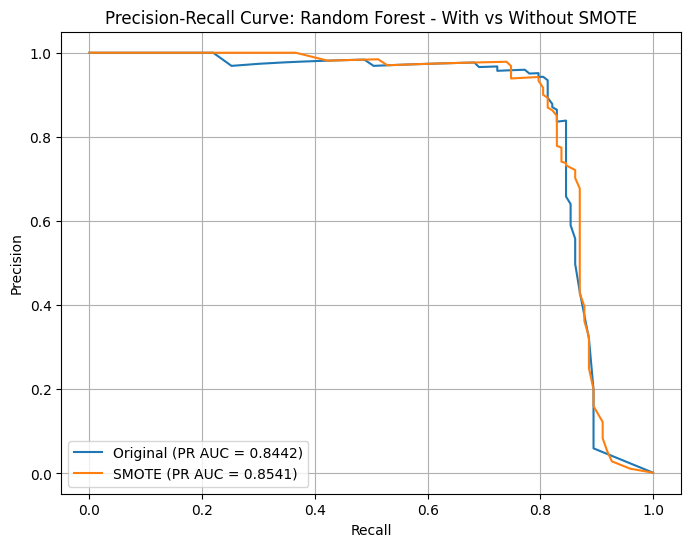

In [8]:
# Plot PR curve
plt.figure(figsize=(8, 6))
plt.plot(recall_rf_orig, precision_rf_orig, label=f'Original (PR AUC = {pr_auc_rf_orig:.4f})')
plt.plot(recall_rf_smote, precision_rf_smote, label=f'SMOTE (PR AUC = {pr_auc_rf_smote:.4f})')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve: Random Forest - With vs Without SMOTE')
plt.legend()
plt.grid()
plt.show()

In [9]:
rf_balanced = RandomForestClassifier(n_estimators=100, random_state=SEED, class_weight='balanced')
rf_balanced.fit(X_train, y_train)
precision_rf_bal, recall_rf_bal, pr_auc_rf_bal = evaluate_model(rf_balanced, X_test, y_test, "RF (Balanced Weights)")


Evaluation: RF (Balanced Weights)
Confusion Matrix:
 [[71076     3]
 [   34    89]]
Classification Report:
               precision    recall  f1-score   support

           0       1.00      1.00      1.00     71079
           1       0.97      0.72      0.83       123

    accuracy                           1.00     71202
   macro avg       0.98      0.86      0.91     71202
weighted avg       1.00      1.00      1.00     71202

ROC AUC Score: 0.9418 (reference)
PR AUC Score: 0.8391


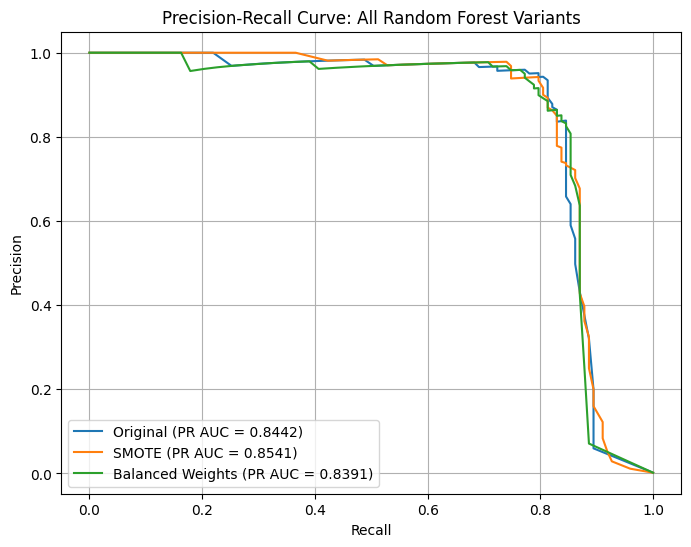

In [10]:
plt.figure(figsize=(8, 6))
plt.plot(recall_rf_orig, precision_rf_orig, label=f'Original (PR AUC = {pr_auc_rf_orig:.4f})')
plt.plot(recall_rf_smote, precision_rf_smote, label=f'SMOTE (PR AUC = {pr_auc_rf_smote:.4f})')
plt.plot(recall_rf_bal, precision_rf_bal, label=f'Balanced Weights (PR AUC = {pr_auc_rf_bal:.4f})')

plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve: All Random Forest Variants')
plt.legend()
plt.grid()
plt.show()


RF (SMOTE) — Best F1 at threshold 0.52
Precision: 0.9423, Recall: 0.7967, F1: 0.8634


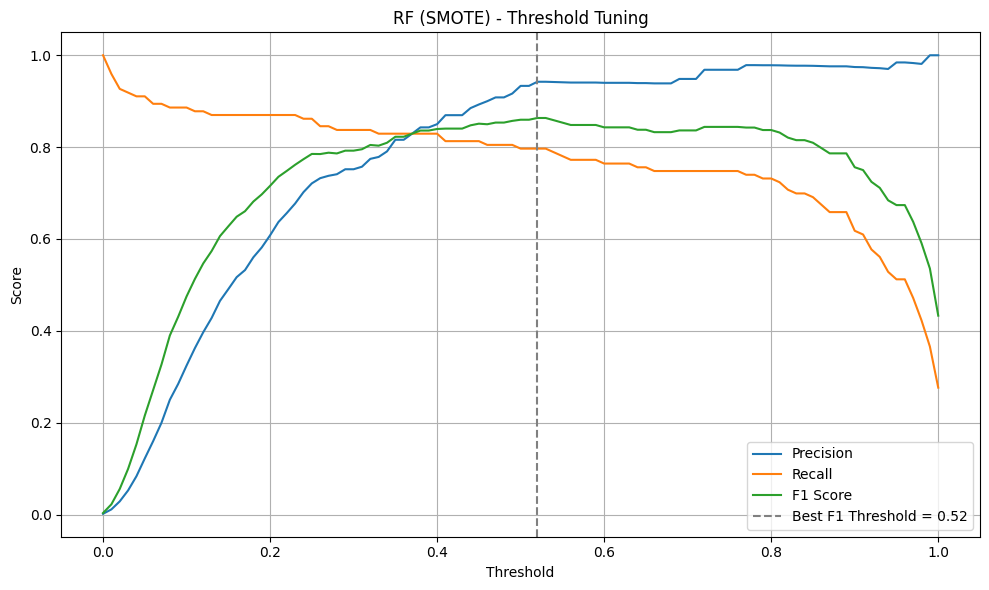

In [12]:
from src.utils import tune_thresholds

y_proba_rf_smote = rf_smote.predict_proba(X_test)[:, 1]
best_threshold_rf_smote = tune_thresholds(y_test, y_proba_rf_smote, model_name="RF (SMOTE)")

In [13]:
y_pred_rf_smote_custom = (y_proba_rf_smote >= best_threshold_rf_smote).astype(int)
print("Confusion Matrix:\n", confusion_matrix(y_test, y_pred_rf_smote_custom))
print("Classification Report:\n", classification_report(y_test, y_pred_rf_smote_custom))

Confusion Matrix:
 [[71073     6]
 [   25    98]]
Classification Report:
               precision    recall  f1-score   support

           0       1.00      1.00      1.00     71079
           1       0.94      0.80      0.86       123

    accuracy                           1.00     71202
   macro avg       0.97      0.90      0.93     71202
weighted avg       1.00      1.00      1.00     71202



In [17]:
from sklearn.metrics import precision_recall_curve, average_precision_score

# Get final precision-recall curve and PR AUC score
precision_final, recall_final, _ = precision_recall_curve(y_test, y_proba_rf_smote)
pr_auc_final = average_precision_score(y_test, y_proba_rf_smote)

# Extract actual precision, recall from classification report
report_final = classification_report(y_test, y_pred_rf_smote_custom, output_dict=True)
precision_final_value = report_final['1']['precision']
recall_final_value = report_final['1']['recall']

# Build summary dataframe
summary_df = pd.DataFrame([
    {
        'Model': 'RF (Original)',
        'Precision': classification_report(y_test, rf_original.predict(X_test), output_dict=True)['1']['precision'],
        'Recall': classification_report(y_test, rf_original.predict(X_test), output_dict=True)['1']['recall'],
        'PR AUC': pr_auc_rf_orig
    },
    {
        'Model': 'RF (SMOTE)',
        'Precision': classification_report(y_test, rf_smote.predict(X_test), output_dict=True)['1']['precision'],
        'Recall': classification_report(y_test, rf_smote.predict(X_test), output_dict=True)['1']['recall'],
        'PR AUC': pr_auc_rf_smote
    },
    {
        'Model': 'RF (Balanced)',
        'Precision': classification_report(y_test, rf_balanced.predict(X_test), output_dict=True)['1']['precision'],
        'Recall': classification_report(y_test, rf_balanced.predict(X_test), output_dict=True)['1']['recall'],
        'PR AUC': pr_auc_rf_bal
    },
    {
        'Model': 'RF (SMOTE + Tuned)',
        'Precision': precision_final_value,
        'Recall': recall_final_value,
        'PR AUC': pr_auc_final
    }
])

summary_df


,Model,Precision,Recall,PR AUC
0,RF (Original),0.950980,0.788618,0.844246
1,RF (SMOTE),0.933333,0.796748,0.854103
2,RF (Balanced),0.967391,0.723577,0.839145
3,RF (SMOTE + Tuned),0.942308,0.796748,0.854103
